In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


In [2]:

# Set random seed for reproducibility
manual_seed = 42
torch.manual_seed(manual_seed)

In [3]:
# Define the Generator network
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [4]:
# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [5]:
# Set parameters
image_size = 64
batch_size = 128
nz = 100 # size of the latent z vector
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator
nc = 3 # number of channels in the training images

In [6]:
# Create the generator
netG = Generator(nz, ngf, nc)

In [7]:
# Create the discriminator
netD = Discriminator(nc, ndf)


In [8]:
# Define loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [9]:
# Load the dataset
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize to [-1, 1]
])


dataset = datasets.ImageFolder(root='/Users/zahidnewaz/Desktop/ProjectFaceGen/CelebA FR Triplets', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

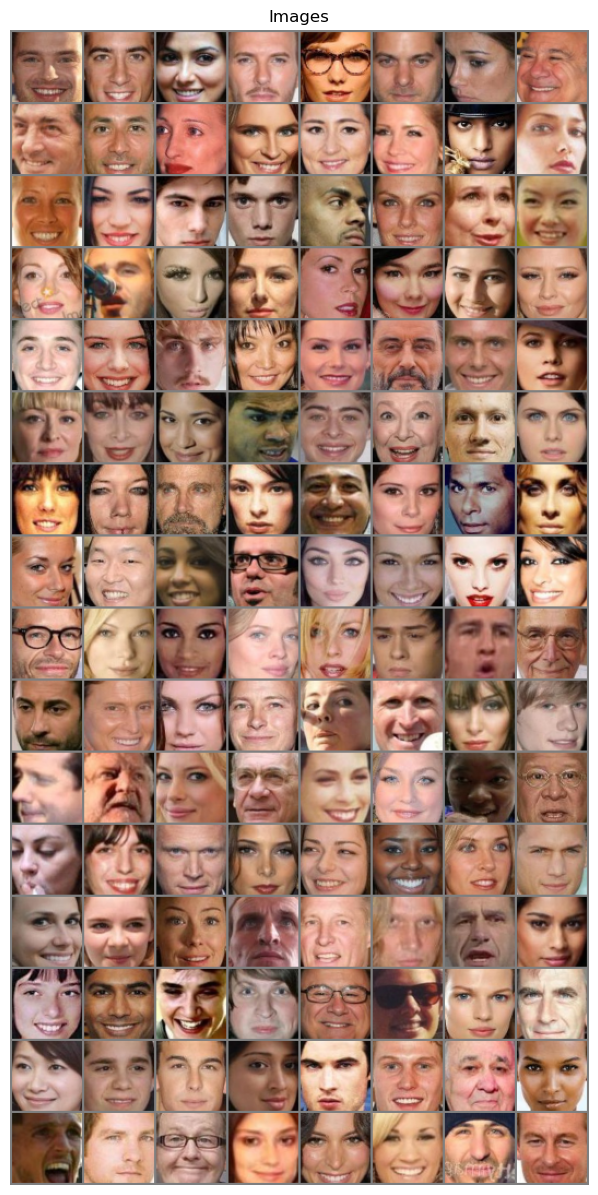

In [10]:
# Function to show an image
def imshow(img, title="Images"):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15, 15))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Show images
imshow(vutils.make_grid(images))

# Optionally, save the grid of images to a file
# plt.savefig('sample_images.png', bbox_inches='tight')

plt.show()

Device: cpu


Epoch [5/5]: 100%|██████████| 363/363 [39:40<00:00,  6.56s/it, D_fake=0.0825, D_real=0.851, Loss_D=0.261, Loss_G=3.92]   


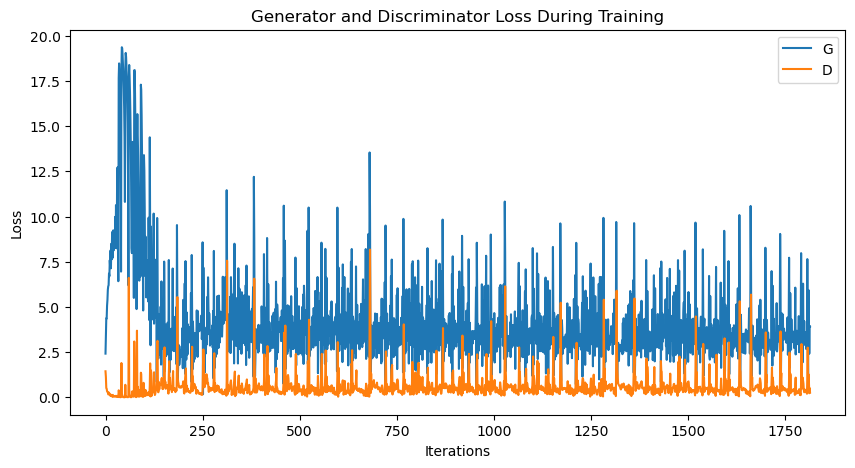

In [11]:
# Training Loop with tqdm

num_epochs = 5

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print("Device:", device)

netG.to(device)
netD.to(device)

# Initialize lists to store loss values
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    loop = tqdm(enumerate(dataloader, 0), total=len(dataloader), leave=True)
    for i, data in loop:
        # Update Discriminator network
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator network
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake).view(-1)
        errG = criterion(output, label.to(torch.float))
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(D_real=D_x, D_fake=D_G_z1, Loss_D=errD.item(), Loss_G=errG.item())

# Plotting loss curves
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

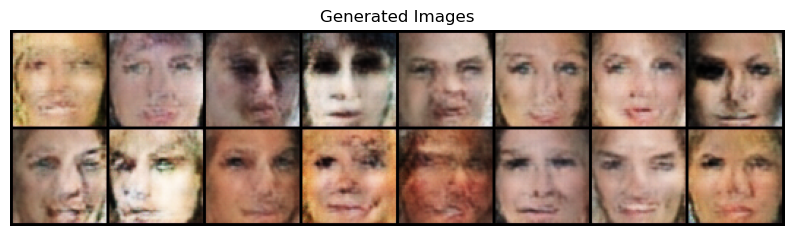

In [12]:
# Generate some images using the trained generator
num_test_samples = 16
noise = torch.randn(num_test_samples, nz, 1, 1, device=device)
fake_images = netG(noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()

# Result evaluation

Plotting Loss Curves


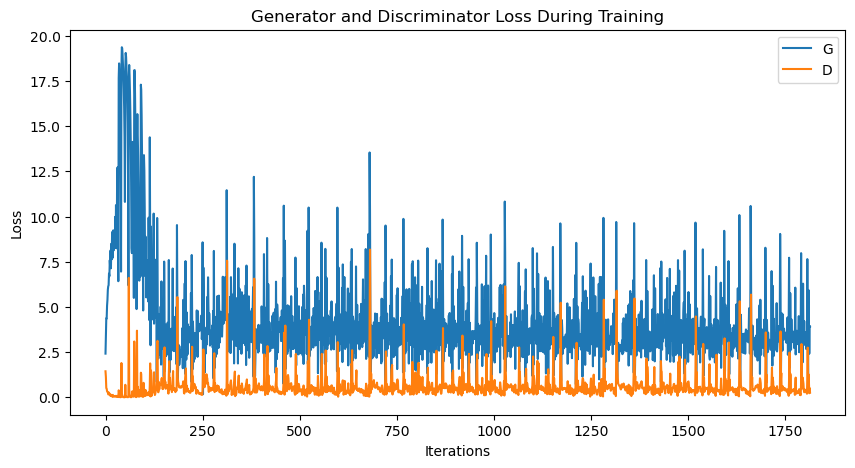

In [13]:
# Plotting loss curves
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Visualizing Generated Images

In [14]:
import os

output_dir = "./results"
os.makedirs(output_dir, exist_ok=True)

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        # Save generated images at intervals
        if i % 100 == 0:
            vutils.save_image(real_cpu, f'{output_dir}/real_samples.png', normalize=True)
            fake = netG(noise)
            vutils.save_image(fake.detach(), f'{output_dir}/fake_samples_epoch_{epoch:03d}_iter_{i:03d}.png', normalize=True)
